<div style="  
    padding: 10px;
    border: 5px solid gray;
    margin: 0; "> 

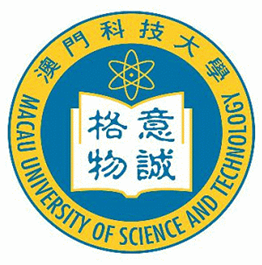
    
<font size=20><center>Macau University of Science and Technology<center></font>
<br/>
<br/>
<font size=18><center> Data Mining <center></font>
<br/>
<br/>
<font size=6><center> **Final Project** <center></font>
<br/>
<br/>
<font size=6 color=blue><center> Recommended system <center></font>
<br/>
<br/>
<font size=6><center> Class-2——  7-Sun Jian-2009853D-IM20-003——    2021- May -25th <center> </font>
    </div>

# Data analysis
##  Import packages

In [1]:
import time, math, os
from tqdm import tqdm
import gc
import pickle
import random
from datetime import datetime
from operator import itemgetter
import numpy as np
import pandas as pd
import warnings
import collections
from collections import defaultdict
warnings.filterwarnings('ignore')

In [2]:
data_path = 'C:\\Users\\sunjin\\Desktop\\Data mining final\\'
save_path = 'C:\\Users\\sunjin\\Desktop\\Data mining final\\result\\'

In [3]:
# debug模式：从训练集中划出一部分数据来调试代码
def get_all_click_sample(data_path, sample_nums=10000):
    all_click = pd.read_csv(data_path + 'train_click_log.csv')
    all_user_ids = all_click.user_id.unique()

    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False) 
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

# 读取点击数据，这里分成线上和线下，如果是为了获取线上提交结果应该讲测试集中的点击数据合并到总的数据中
# 如果是为了线下验证模型的有效性或者特征的有效性，可以只使用训练集
def get_all_click_df(data_path='./data/', offline=True):
    if offline:
        all_click = pd.read_csv(data_path + 'train_click_log.csv')
    else:
        trn_click = pd.read_csv(data_path + 'train_click_log.csv')
        tst_click = pd.read_csv(data_path + 'testA_click_log.csv')

        all_click = trn_click.append(tst_click)
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

In [4]:
# 全量训练集
all_click_df = get_all_click_df(data_path, offline=False)
all_click_df.head(5)

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,199999,160417,1507029570190,4,1,17,1,13,1
1,199999,5408,1507029571478,4,1,17,1,13,1
2,199999,50823,1507029601478,4,1,17,1,13,1
3,199998,157770,1507029532200,4,1,17,1,25,5
4,199998,96613,1507029671831,4,1,17,1,25,5


# Task 1

<div style="  
    padding: 10px;
    border: 5px solid gray;
    margin: 0; "> 
    
<font size=5><center>**基于物品的协同过滤算法**（ItemCF）<center></font>

<font size=4 color=blue>**1.基本思想**</font>

&ensp;&ensp;<font size=3.5>ItemCF算法通过计算用户的历史行为记录，来分析物品之间的相似度：如果喜欢物品A的用户大多数也喜欢物品B，那么认为物品A与物品B具有一定的相似度。这就很容易为推荐结果做出合理的解释。假设，$N(A)$和$N(B)$分别是喜欢物品A和物品B的用户数量,$\lvert N(A)\cap N(B)\rvert$是既喜欢A又喜欢B的用户的数量，那么物品A和物品B的相似度为（喜欢A的用户中有多少人也喜欢B）：</font>

<font size=3.5 color=blue>$$w_{AB}=\frac{\lvert N(A)\cap N(B)\rvert}{\lvert N(A)\rvert}$$</font>

&ensp;&ensp;<font size=3.5>如果B是个很热门的商品，那么$w_{AB}$将会接近于1（因为喜欢A的人都喜欢B），这会造成任何其他物品与某个热门物品都很相似。因此，我们对公式作一些修改，加上一个惩罚物品B的权重因子，得到了公式：</font>

<font size=3.5 color=blue>$$w_{AB}=\frac{\lvert N(A)\cap N(B)\rvert}{\sqrt{\lvert N(A)\rvert\lvert N(B)\rvert}}$$</font>

<font size=4 color=blue>**2.用户活跃度对物品相似度的影响（ItemCF-IUF）**</font>

&ensp;&ensp;<font size=3.5>在ItemCF中，两个物品之间能产生相似度是因为它们共同出现在了多个用户的兴趣物品列表中，因此用户会对其兴趣列表中的两两物品的相似度产生贡献。但是，不同的用户的贡献是不相同的。对于过于活跃的用户，往往忽略他们的兴趣列表假设，因为他们对物品之间相似度的贡献更小。$N(u)$是用户u喜欢的物品列表，那么用户u的IUF参数为:</font>
    
<font size=3.5 color=blue>$$\frac{1}{\log{(1+\lvert N(u)\rvert)}}$$</font>

&ensp;&ensp;<font size=3.5>所以我们可以得到增加了IUF参数的物品相似度公式:</font>

<font size=3.5 color=blue>$$w_{AB}=\frac{\sum_{u \in N(A)\cap N(B)}\frac{1}{\log{(1+\lvert N(u)\rvert)}}}{\sqrt{\lvert N(A)\rvert\lvert N(B)\rvert}}$$</font>

<div style="  
    padding: 10px;
    border: 5px solid gray;
    margin: 0; "> 
    
<font size=5><center>**评分指标**<center></font>

&ensp;&ensp;<font size=3.5>采用的评分方式为 MRR(Mean Reciprocal Rank)</font>

<font size=3.5 color=blue>$$ score(user)=\sum_{k=1}^5 \frac{s(user,k)}{k}$$</font>

<font size=3.5 color=blue>$$ TotalScore=\frac{1}{N}\sum_{i=1}^N score(user_i)$$</font>

&ensp;&ensp;<font size=3.5>其中$s(user, k)$为预测结果是否命中最后一条点击数据，命中的话$s(user, k)=1$，未命中则$s(user, k)=0$。$TotalScore$为最终的模型性能评分。</font>

## Get the user's clicked article sequence according to the click time  {user1: [(item1, time1), (item2, time2)..]...}

In [5]:
def get_user_item_time(click_df):
    
    click_df = click_df.sort_values('click_timestamp')#根据全数据集中的'click_timestamp'列 做升序排列
    
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    user_item_time_df = click_df.groupby('user_id')['click_article_id', 'click_timestamp'].apply(lambda x: make_item_time_pair(x))\
                                    .reset_index().rename(columns={0: 'item_time_list'})
    # 上面对全数据集click_df根据它的'user_id'做了分组操作（GroupBy），这个操作还挺不错的。
    #一开始我也想这么做，可惜不知道有这个函数，得出来的结果就是下面形式，一个用户id对应着他看的新闻id和时间
    # 用了一个匿名函数 其实就是为了搞个zip 即[(233917, 1507036600306)]
    
    #user_id
    #196381                            [(233917, 1507036600306)]
    #196382     [(5408, 1507036793030), (206661, 1507036823030)]
    #196383    [(50823, 1507039157875), (206934, 1507039187875)]
    
    #上面代码中的.reset_index().rename(columns={0: 'item_time_list'})是为了把这个结果变成datafream格式
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    #上面代码的操作就是改个类型
    return user_item_time_dict
    #最后得到的结果是这样的字典类型
    #{196381: [(233917, 1507036600306)],
    #196382: [(5408, 1507036793030), (206661, 1507036823030)],
    #196383: [(50823, 1507039157875), (206934, 1507039187875)],...}

## Get the article ID of the top K clicks

In [6]:
def get_item_topk_click(click_df, k):
    topk_click = click_df['click_article_id'].value_counts().index[:k]
    return topk_click
#最后的结果是这样的
#Int64Index([272143, 156624, 199198, 156560,  64329, 336476, 348111, 175040,
#            182513, 160417, 162655, 157332, 198659, 284474, 199197,  50823,
#            285343, 233917, 156447, 286161, 158536, 161409,  96077, 235230,
#            285298, 158229,   5408, 166430,  36605, 162765, 285648, 284547,
#            129029, 160974, 324823,  59829, 158082, 313431, 182394,  70646,
#            206934, 224171, 338350,  71500, 236726, 107039, 208077, 299697,
#            208322,  61611],
#           dtype='int64')

## Calculation of the similarity matrix between items

In [7]:
# 这个函数是为了计算物品之间的相似度矩阵，最后保存到本地文件中，命名为itemcf_i2i_sim.pkl，后面给用户推荐新闻的时候
#会再用pickle.load来读取这个文件
def itemcf_sim(df):
    user_item_time_dict = get_user_item_time(df)#这里用了get_user_item_time函数，就是上面定义的函数
    
    # 计算物品相似度
    i2i_sim = {}
    item_cnt = defaultdict(int)
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for i, i_click_time in item_time_list:
            #item_time_list的格式就是这样的[(233917, 1507036600306)]
            item_cnt[i] += 1
            i2i_sim.setdefault(i, {})
            for j, j_click_time in item_time_list:
                #item_time_list的格式就是这样的[(233917, 1507036600306)]
                if(i == j):
                    continue
                i2i_sim[i].setdefault(j, 0)
                
                i2i_sim[i][j] += 1 / math.log(len(item_time_list) + 1)#求IUF参数的值的sum
                
    i2i_sim_ = i2i_sim.copy()
    for i, related_items in i2i_sim.items():
        for j, wij in related_items.items():
            i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])#这里wij就是上面i2i_sim，即IUF参数的值的sum
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_, open(save_path + 'itemcf_i2i_sim.pkl', 'wb'))
    
    return i2i_sim_

## Definition and assignment of variables

In [8]:
# 先看这个定义会更好一些
# 定义
user_recall_items_dict = collections.defaultdict(dict)

# 获取 用户 - 文章 - 点击时间的字典 #这里又用了get_user_item_time函数
user_item_time_dict = get_user_item_time(all_click_df)

# 读取文章相似度 #这就是上面说过的 用pickle.load读取本地文件储存的相似度矩阵
i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))

# 相似文章的数量 #这里自己设置一个数量，表示要找到几个和某一篇最相似的文章
sim_item_topk = 10

# 召回文章数量 #这里就是表示到底给用户推荐几个文章
recall_item_num = 10

# 用户热度补全 #这里是说，如果给用户推荐的文章个数达不到我们预期，我们就用热门的文章替补
item_topk_click = get_item_topk_click(all_click_df, k=50)

## Recall of Collaborative Filtering  based on Article

In [9]:
# 基于文章的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click): 
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id] 
    # 注意，此时获取得到的是一个元组列表，需要将里面的user_id提取出来
    # 上面代码的结果 我查看了用户199998的历史浏览情况
    #[(157770, 1507029532200),
    #(96613, 1507029671831),
    #(144978, 1507029804858),
    #(285371, 1507029834858)]
    
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}
    #上面的代码是得到某个用户他历史点击过的文章，根据文章id大小排序
    # 代码结果{96613, 144978, 157770, 285371}（这里就是用户199998他历史点击的结果）
    
    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        #这里的enumerate(user_hist_items)形式是这样的
        #[(0, (157770, 1507029532200)),
        #(1, (96613, 1507029671831)),
        #(2, (144978, 1507029804858)),
        #(3, (285371, 1507029834858))]
        
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j  in user_hist_items_:
                continue
                
            item_rank.setdefault(j, 0)
            item_rank[j] +=  wij
        #上面代码第一段的目的是找到和用户的历史点击文章里某一个文章（j）最相似的10个（sim_item_topk）文章
        #结果返回文章id和它的相似度 类似这样[(114743, 0.9102392266268373)]，这里我就找了和文章348111相似的一个文章
        #写入循环后就可以找他的十个相似的文章，还可以找别的文章的十个相似的文章。
        
        #continue 语句用于跳过 for 和 while 循环中的本次循环，其后的语句在本次循环中将不再执行，同时程序将执行下一轮循环。
        #这就说明 第二段代码if j  in user_hist_items_: continue的目的：#如果返回的最相似的10个文章这在用户的
        #历史点击文章里，则不用管。如果不在，那就要把这些文章推荐给用户，执行下面代码item_rank.setdefault(j, 0)
        #item_rank[j] +=  wij 最后在item_rank里储存那些不在用户历史点击文章里面的文章，即推荐给用户
        #item_rank 的形式为 {114743: 0.9102392266268373}（这里我只写了一个）

    # 如果我们推荐的文章数量不足10个，则用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):#这里用了上面定义的 item_topk_click 函数
            if item in item_rank.items(): 
                continue #如果这50个热门的文章在推荐列表里面则不用填充了，如果不在，执行以下代码
            item_rank[item] = - i - 100 # 随便给个负数就行，因为我们填充进去的没有相似度，就随便设置一个
            #类型是这样的{114743: 0.9102392266268373, 208322: -148} 这里我就加入了208322这个文章
            if len(item_rank) == recall_item_num:#推荐的个数达到十个了，就跳出循环
                break
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
    #返回list
    return item_rank

In [10]:
#这个就是调用上面item_based_recommend函数，再用上面的定义来解决问题，得到的结果是字典形式的
for user in tqdm(all_click_df['user_id'].unique()):
    #all_click_df['user_id'].unique()的代码的结果array([199998, 199987, 199984, ..., 198997, 199015, 199140], dtype=int64) 
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, 
                                                        sim_item_topk, recall_item_num, item_topk_click)

100%|██████████████████████████████████████████████████████████████████████████| 250000/250000 [56:33<00:00, 73.68it/s]


## Convert the result into dataframe

In [11]:
# 将字典的形式转换成df
user_item_score_list = []

for user, items in tqdm(user_recall_items_dict.items()):
    for item, score in items:
        user_item_score_list.append([user, item, score])

recall_df = pd.DataFrame(user_item_score_list, columns=['user_id', 'click_article_id', 'pred_score'])

100%|███████████████████████████████████████████████████████████████████████| 250000/250000 [00:05<00:00, 48501.04it/s]


In [12]:
recall_df.head(12)

,user_id,click_article_id,pred_score
0,199999,276970,0.172377
1,199999,158536,0.106969
2,199999,286321,0.097774
3,199999,108855,0.092462
4,199999,162655,0.091407
5,199999,50864,0.085675
6,199999,123818,0.080765
7,199999,156625,0.077639
8,199999,124228,0.077581
9,199999,36399,0.077381


## Generate submission file

In [43]:
# 生成提交文件
def submit(recall_df, topk=5, model_name=None):
    recall_df = recall_df.sort_values(by=['user_id', 'pred_score'])
    recall_df['rank'] = recall_df.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    
    # 判断是不是每个用户都有5篇文章及以上
    tmp = recall_df.groupby('user_id').apply(lambda x: x['rank'].max())
    assert tmp.min() >= topk
    
    del recall_df['pred_score']
    submit = recall_df[recall_df['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()
    
    submit.columns = [int(col) if isinstance(col, int) else col for col in submit.columns.droplevel(0)]
    # 按照提交格式定义列名
    submit = submit.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2', 
                                                  3: 'article_3', 4: 'article_4', 5: 'article_5'})
    
    save_name = save_path + model_name + '_' + datetime.today().strftime('%m-%d') + '.csv'
    submit.to_csv(save_name, index=False, header=True)



# 获取测试集
tst_click = pd.read_csv(data_path + 'testA_click_log.csv')
tst_users = tst_click['user_id'].unique()

# 从所有的召回数据中将测试集中的用户选出来
tst_recall = recall_df[recall_df['user_id'].isin(tst_users)]

# 生成提交文件
submit(tst_recall, topk=5, model_name='itemcf_baseline')

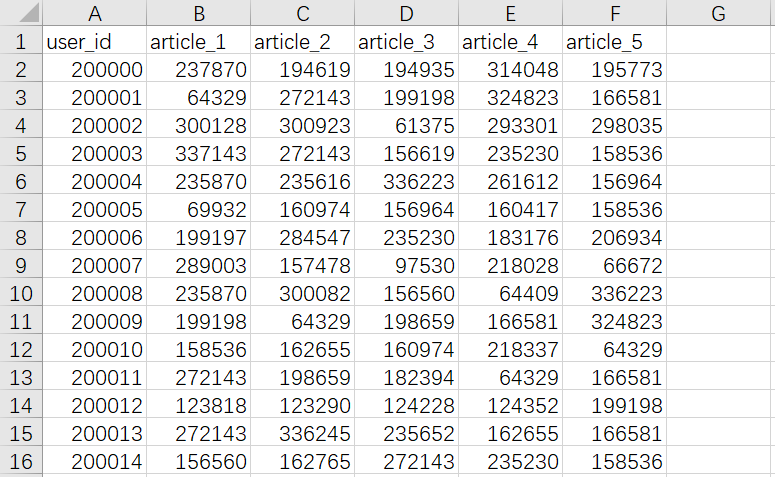

In [49]:
# 读取文章的基本属性 
def get_item_info_df(data_path):
    item_info_df = pd.read_csv(data_path + 'articles.csv')
    
    # 为了方便与训练集中的click_article_id拼接，需要把article_id修改成click_article_id
    item_info_df = item_info_df.rename(columns={'article_id': 'click_article_id'})
    
    return item_info_df

In [50]:
# 获取文章id对应的基本属性，保存成字典的形式，方便后面召回阶段，冷启动阶段直接使用
def get_item_info_dict(item_info_df):
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    item_info_df['created_at_ts'] = item_info_df[['created_at_ts']].apply(max_min_scaler)
    
    item_type_dict = dict(zip(item_info_df['click_article_id'], item_info_df['category_id']))
    item_words_dict = dict(zip(item_info_df['click_article_id'], item_info_df['words_count']))
    item_created_time_dict = dict(zip(item_info_df['click_article_id'], item_info_df['created_at_ts']))
    
    return item_type_dict, item_words_dict, item_created_time_dict

In [51]:
item_info_df = get_item_info_df(data_path)

In [53]:
item_info_df

,click_article_id,category_id,created_at_ts,words_count
0,0,0,0.978432,168
1,1,1,0.680295,189
2,2,1,0.689493,250
3,3,1,0.688942,230
4,4,1,0.685078,162
...,...,...,...,...
364042,364042,460,0.759646,144
364043,364043,460,0.759962,463
364044,364044,460,0.825854,177
364045,364045,460,0.986232,126


In [52]:
# 获取文章的属性信息，保存成字典的形式方便查询
item_type_dict, item_words_dict, item_created_time_dict = get_item_info_dict(item_info_df)

In [54]:
def itemcf_sim(df, item_created_time_dict):
    """
        文章与文章之间的相似性矩阵计算
        :param df: 数据表
        :item_created_time_dict:  文章创建时间的字典
        return : 文章与文章的相似性矩阵
        
        思路: 基于物品的协同过滤 + 关联规则
    """
    
    user_item_time_dict = get_user_item_time(df)
    
    # 计算物品相似度
    i2i_sim = {}
    item_cnt = defaultdict(int)
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for loc1, (i, i_click_time) in enumerate(item_time_list):
            item_cnt[i] += 1
            i2i_sim.setdefault(i, {})
            for loc2, (j, j_click_time) in enumerate(item_time_list):
                if(i == j):
                    continue
                    
                # 考虑文章的正向顺序点击和反向顺序点击 loc相对位置
                # 点击loc1后很可能会继续点loc2，loc2权重更高
                loc_alpha = 1.0 if loc2 > loc1 else 0.7
                # 位置信息权重，其中的参数可以调节
                # 两篇文章的相对位置越远np.abs(loc2 - loc1)，它们的相似度就越低
                loc_weight = loc_alpha * (0.9 ** (np.abs(loc2 - loc1) - 1))
                # 点击时间权重，其中的参数可以调节
                # 点击时间相差越远，它们的相似度就越低
                click_time_weight = np.exp(0.7 ** np.abs(i_click_time - j_click_time))
                # 两篇文章创建时间的权重，其中的参数可以调节
                # 刚创建不久的新文章和旧文章相似度低
                created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                i2i_sim[i].setdefault(j, 0)
                # 考虑多种因素的权重计算最终的文章之间的相似度
                i2i_sim[i][j] += loc_weight * click_time_weight * created_time_weight / math.log(len(item_time_list) + 1)
                
    i2i_sim_ = i2i_sim.copy()
    for i, related_items in i2i_sim.items():
        for j, wij in related_items.items():
            i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_, open(save_path + 'itemcf_i2i_sim.pkl', 'wb'))
    
    return i2i_sim_

In [55]:
i2i_sim = itemcf_sim(all_click_df, item_created_time_dict)

100%|█████████████████| 250000/250000 [09:51<00:00, 422.60it/s]


In [57]:
for user in tqdm(all_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, 
                                                        sim_item_topk, recall_item_num, item_topk_click)

100%|████████████████| 250000/250000 [3:00:55<00:00, 23.03it/s]


In [58]:
# 将字典的形式转换成df
user_item_score_listnew = []

for user, items in tqdm(user_recall_items_dict.items()):
    for item, score in items:
        user_item_score_listnew.append([user, item, score])

recall_dfnew = pd.DataFrame(user_item_score_listnew, columns=['user_id', 'click_article_id', 'pred_score'])

100%|███████████████| 250000/250000 [00:07<00:00, 33298.67it/s]


In [59]:
# 生成提交文件
def submit(recall_dfnew, topk=5, model_name=None):
    recall_dfnew = recall_dfnew.sort_values(by=['user_id', 'pred_score'])
    recall_dfnew['rank'] = recall_dfnew.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    
    # 判断是不是每个用户都有5篇文章及以上
    tmp = recall_dfnew.groupby('user_id').apply(lambda x: x['rank'].max())
    assert tmp.min() >= topk
    
    del recall_dfnew['pred_score']
    submit = recall_dfnew[recall_dfnew['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()
    
    submit.columns = [int(col) if isinstance(col, int) else col for col in submit.columns.droplevel(0)]
    # 按照提交格式定义列名
    submit = submit.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2', 
                                                  3: 'article_3', 4: 'article_4', 5: 'article_5'})
    
    save_name = save_path + model_name + '_' + datetime.today().strftime('%m-%d') + '.csv'
    submit.to_csv(save_name, index=False, header=True)



# 获取测试集
tst_click = pd.read_csv(data_path + 'testA_click_log.csv')
tst_users = tst_click['user_id'].unique()

# 从所有的召回数据中将测试集中的用户选出来
tst_recall = recall_dfnew[recall_dfnew['user_id'].isin(tst_users)]

# 生成提交文件
submit(tst_recall, topk=5, model_name='itemcf_baseline')

# LGB